<a href="https://colab.research.google.com/github/vesc0/transactions-analysis/blob/main/financial_transactions_fraud_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fraud Detection in Financial Transactions

In [1]:
# Import the necesarry libraries
# Core libraries
import numpy as np
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
# Google Drive
from google.colab import drive

drive.mount('/content/drive')

dataset = pd.read_csv('/content/drive/MyDrive/fraud_data/Fraud.csv')
dataset.head()

Mounted at /content/drive


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


This dataset contains simulated financial transaction records, representing customer activity over a period of 30 days, where each time step corresponds to one hour. The dataset includes transaction details such as transaction type, amount, origin and destination accounts, and account balances before and after each transaction.

In [2]:
# Summary of the dataset
dataset.info()
dataset['isFraud'].value_counts()
dataset['isFraud'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


,proportion
isFraud,
0,0.998709
1,0.001291


A small fraction of transactions are labeled as fraudulent (isFraud = 1), representing behavior where fraudulent agents attempt to transfer funds and subsequently cash them out. The dataset is highly imbalanced, with fraudulent transactions accounting for approximately 0.13% of all observations, which reflects real-world fraud detection challenges.

In [3]:
# Check if there are missing data fields in the dataset
missing_data = dataset.isnull().sum()
columns_with_missing_data = missing_data[missing_data > 0]

# Show result
if not columns_with_missing_data.empty:
    print("Columns with missing data:")
    print(columns_with_missing_data)
else:
    print("No missing data found in the dataset.")

No missing data found in the dataset.


In [4]:
# Check fraud probability in each transaction type
dataset.groupby('type')['isFraud'].mean().sort_values(ascending=False)

,isFraud
type,
TRANSFER,0.007688
CASH_OUT,0.001840
CASH_IN,0.000000
DEBIT,0.000000
PAYMENT,0.000000


An analysis of conditional fraud probabilities by transaction type shows that fraudulent activity occurs exclusively in TRANSFER and CASH_OUT transactions. No fraudulent cases are observed in PAYMENT, DEBIT, or CASH_IN transactions. This aligns with the dataset description, where fraudulent agents attempt to transfer funds and subsequently cash them out, confirming that transaction type is a strong indicator of fraudulent behavior.

In [5]:
# Compare fraudulent vs non-fraudulent transactions by amount (distribution)
dataset.groupby('isFraud')['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,6354407.0,1.781970e+05,5.962370e+05,0.01,13368.395,74684.72,208364.76,92445516.64
1,8213.0,1.467967e+06,2.404253e+06,0.00,127091.330,441423.44,1517771.48,10000000.00


A comparison of transaction amount distributions reveals substantial differences between fraudulent and non-fraudulent transactions. Fraudulent transactions have significantly higher mean and median values, with the median fraud amount being approximately six times larger than that of legitimate transactions. However, the presence of very large non-fraudulent transactions indicates an overlap between the two distributions, implying that transaction amount alone is insufficient for perfect fraud detection.

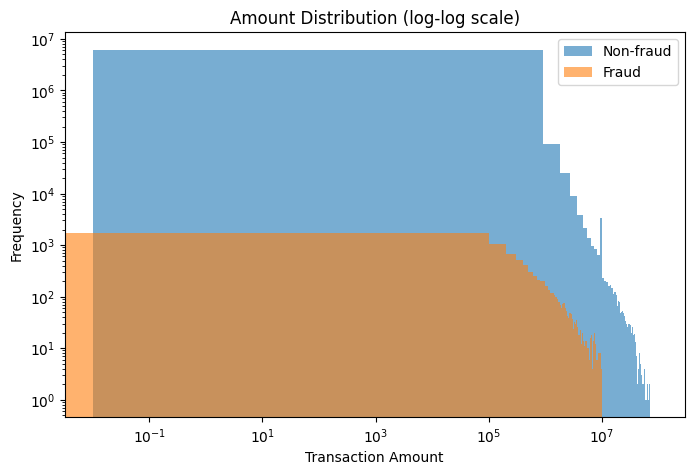

In [6]:
# Visualization
plt.figure(figsize=(8,5))
plt.hist(
    dataset.loc[dataset['isFraud'] == 0, 'amount'],
    bins=100, alpha=0.6, label='Non-fraud'
)
plt.hist(
    dataset.loc[dataset['isFraud'] == 1, 'amount'],
    bins=100, alpha=0.6, label='Fraud'
)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Amount Distribution (log-log scale)')
plt.show()

The overlaid histograms of transaction amounts, plotted on a log–log scale, reveal highly skewed distributions for both fraudulent and non-fraudulent transactions. While fraudulent transactions tend to involve larger amounts on average, there is substantial overlap between the two distributions, particularly at lower transaction values. Additionally, the dominance of non-fraud transactions across all amount ranges reflects the strong class imbalance present in the dataset rather than an absence of fraud at high values. These findings indicate that transaction amount alone cannot reliably distinguish fraudulent behavior and must be considered in combination with other features.

In [7]:
# Relationship between type and amount for fraud
dataset[dataset['isFraud'] == 1].groupby('type')['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
CASH_OUT,4116.0,1.455103e+06,2.393842e+06,0.0,125464.45,435516.905,1500761.03,10000000.0
TRANSFER,4097.0,1.480892e+06,2.414890e+06,63.8,128417.96,445705.760,1534985.07,10000000.0


A comparison of fraudulent transaction amounts by transaction type shows that CASH_OUT and TRANSFER fraud cases have nearly identical distributions in terms of mean, median, and dispersion. This suggests that fraudulent behavior follows a consistent monetary pattern regardless of the specific transaction type. Combined with the near-equal frequency of these two fraud categories, the results support the dataset’s underlying fraud scenario in which funds are transferred and subsequently cashed out.

ML

In [8]:
# Features to keep
features = ['step', 'type', 'amount', 'oldbalanceOrg', 'oldbalanceDest']

# Target variable
target = 'isFraud'

# Separate features (X) and target (y)
X = dataset[features].copy()
y = dataset[target].copy()

# Check the first few rows
X.head()

,step,type,amount,oldbalanceOrg,oldbalanceDest
0,1,PAYMENT,9839.64,170136.0,0.0
1,1,PAYMENT,1864.28,21249.0,0.0
2,1,TRANSFER,181.00,181.0,0.0
3,1,CASH_OUT,181.00,181.0,21182.0
4,1,PAYMENT,11668.14,41554.0,0.0


In [9]:
# One-hot encoding for 'type'
X = pd.get_dummies(X, columns=['type'], prefix='type')

# Check new columns
X.head()

,step,amount,oldbalanceOrg,oldbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,0.0,False,False,False,True,False
1,1,1864.28,21249.0,0.0,False,False,False,True,False
2,1,181.00,181.0,0.0,False,False,False,False,True
3,1,181.00,181.0,21182.0,False,True,False,False,False
4,1,11668.14,41554.0,0.0,False,False,False,True,False


In [10]:
# Check how imbalanced the target is
y.value_counts(normalize=True)

,proportion
isFraud,
0,0.998709
1,0.001291


In [11]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # maintain fraud ratio
)

# Check sizes
print("Training samples:", X_train.shape[0])
print("Validation samples:", X_valid.shape[0])

Training samples: 5090096
Validation samples: 1272524


In [12]:
# Scale
from sklearn.preprocessing import StandardScaler

# Columns to scale
num_features = ['step', 'amount', 'oldbalanceOrg', 'oldbalanceDest']

# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both train and validation
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_valid[num_features] = scaler.transform(X_valid[num_features])

# Check the first few rows
X_train.head()

,step,amount,oldbalanceOrg,oldbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
292779,-1.604574,-0.282169,-0.273409,-0.323308,False,False,False,True,False
499763,-1.569442,-0.287248,-0.288733,-0.323308,False,False,False,True,False
2970411,-0.086865,0.300938,-0.288733,-0.179414,False,True,False,False,False
3137549,-0.051733,-0.286868,-0.288733,-0.323308,False,False,False,True,False
1500682,-0.705191,0.063257,4.229095,0.393047,True,False,False,False,False


In [13]:
# Feature engineering
# Extract hour of the day
X_train['hour'] = X_train['step'] % 24
X_valid['hour'] = X_valid['step'] % 24

# Compute delta balance
X_train['deltaOrig'] = X_train['oldbalanceOrg'] - X_train['oldbalanceDest']
X_valid['deltaOrig'] = X_valid['oldbalanceOrg'] - X_valid['oldbalanceDest']

# Check first rows
X_train.head()

,step,amount,oldbalanceOrg,oldbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,hour,deltaOrig
292779,-1.604574,-0.282169,-0.273409,-0.323308,False,False,False,True,False,22.395426,0.049899
499763,-1.569442,-0.287248,-0.288733,-0.323308,False,False,False,True,False,22.430558,0.034575
2970411,-0.086865,0.300938,-0.288733,-0.179414,False,True,False,False,False,23.913135,-0.109319
3137549,-0.051733,-0.286868,-0.288733,-0.323308,False,False,False,True,False,23.948267,0.034575
1500682,-0.705191,0.063257,4.229095,0.393047,True,False,False,False,False,23.294809,3.836049


Random Forest

In [14]:
# Import the Random Forest model and metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the Random Forest
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1 # use all CPU cores
)

# Combine features and target temporarily
data_sample = pd.concat([X_train, y_train], axis=1)
# Sample 100k rows, stratify by isFraud
data_sampled = data_sample.groupby('isFraud', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 5000), random_state=42) # keep ~5k fraud and ~95k non-fraud roughly
    )
# Separate features and target again
X_train_small = data_sampled.drop('isFraud', axis=1)
y_train_small = data_sampled['isFraud']

# Train the model
rf_model.fit(X_train_small, y_train_small)

# Make predictions on validation set
y_pred = rf_model.predict(X_valid)

# Evaluate performance
# Confusion Matrix
cm = confusion_matrix(y_valid, y_pred)
print("Confusion Matrix:\n", cm)
# Classification Report
report = classification_report(y_valid, y_pred)
print("Classification Report:\n", report)

/tmp/ipython-input-3425693760.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_sampled = data_sample.groupby('isFraud', group_keys=False).apply(


Confusion Matrix:
 [[1232646   38235]
 [     19    1624]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98   1270881
           1       0.04      0.99      0.08      1643

    accuracy                           0.97   1272524
   macro avg       0.52      0.98      0.53   1272524
weighted avg       1.00      0.97      0.98   1272524



XGBoost

In [15]:
# Import XGBoost
from xgboost import XGBClassifier

# Initialize the model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=77,  # imbalance ratio
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train on small sampled dataset
xgb_model.fit(X_train_small, y_train_small)

# Predict on validation set
y_pred_xgb = xgb_model.predict(X_valid)

# Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix
# Confusion Matrix
cm_xgb = confusion_matrix(y_valid, y_pred_xgb)
print("Confusion Matrix:\n", cm_xgb)
# Classification Report
report_xgb = classification_report(y_valid, y_pred_xgb)
print("Classification Report:\n", report_xgb)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:58:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[1177811   93070]
 [      2    1641]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96   1270881
           1       0.02      1.00      0.03      1643

    accuracy                           0.93   1272524
   macro avg       0.51      0.96      0.50   1272524
weighted avg       1.00      0.93      0.96   1272524



Logistic Regression

In [16]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize Logistic Regression
log_model = LogisticRegression(
    solver='liblinear',  # good for small datasets and binary classification
    class_weight='balanced',  # handle imbalanced data
    random_state=42
)

# Train the model
log_model.fit(X_train_small, y_train_small)

# Make predictions on validation set
y_pred_log = log_model.predict(X_valid)

# Evaluate performance
# Confusion Matrix
cm_log = confusion_matrix(y_valid, y_pred_log)
print("Confusion Matrix:\n", cm_log)
# Classification Report
report_log = classification_report(y_valid, y_pred_log)
print("Classification Report:\n", report_log)

Confusion Matrix:
 [[1039058  231823]
 [    178    1465]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90   1270881
           1       0.01      0.89      0.01      1643

    accuracy                           0.82   1272524
   macro avg       0.50      0.85      0.46   1272524
weighted avg       1.00      0.82      0.90   1272524

